In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Image preparation

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
# Organize data into train, valid, test dirs
os.chdir('/Documents/data/flower-photos')

dirs = os.listdir()

if os.path.isdir('train/daisy/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for dir in dirs:
        if dir != 'train' and dir != 'test' and dir != 'valid':
            shutil.move(dir, 'train')
            os.mkdir(f'valid/{dir}')
            os.mkdir(f'test/{dir}')
              
            valid_samples = random.sample(os.listdir(f'train/{dir}'), 150)
            for j in valid_samples:
                shutil.move(f'train/{dir}/{j}', f'valid/{dir}')

            test_samples = random.sample(os.listdir(f'train/{dir}'), 25)
            for k in test_samples:
                shutil.move(f'train/{dir}/{k}', f'test/{dir}')
os.chdir('../..')

daisy
dandelion
roses
sunflowers
tulips


In [47]:
train_path = 'data/flower-photos/train'
valid_path = 'data/flower-photos/valid'
test_path = 'data/flower-photos/test'

In [48]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=5, shuffle=False)

Found 2795 images belonging to 5 classes.
Found 750 images belonging to 5 classes.
Found 125 images belonging to 5 classes.


# Modify model

In [49]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [50]:
x = mobile.layers[-6].output
output = Dense(units=5, activation='softmax')(x)

In [51]:
model = Model(inputs=mobile.input, outputs=output)

In [52]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [53]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

# Train model

In [54]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [55]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Epoch 1/30
559/559 - 162s - loss: 0.6221 - accuracy: 0.7893 - val_loss: 0.3068 - val_accuracy: 0.9053
Epoch 2/30
559/559 - 143s - loss: 0.2951 - accuracy: 0.8916 - val_loss: 0.4816 - val_accuracy: 0.8440
Epoch 3/30
559/559 - 161s - loss: 0.2403 - accuracy: 0.9199 - val_loss: 0.3577 - val_accuracy: 0.8707
Epoch 4/30
559/559 - 148s - loss: 0.1743 - accuracy: 0.9406 - val_loss: 0.2717 - val_accuracy: 0.9120
Epoch 5/30
559/559 - 147s - loss: 0.1360 - accuracy: 0.9599 - val_loss: 0.4000 - val_accuracy: 0.8693
Epoch 6/30
559/559 - 139s - loss: 0.1056 - accuracy: 0.9689 - val_loss: 0.4403 - val_accuracy: 0.8667
Epoch 7/30
559/559 - 136s - loss: 0.1169 - accuracy: 0.9639 - val_loss: 0.3125 - val_accuracy: 0.9133
Epoch 8/30
559/559 - 137s - loss: 0.0696 - accuracy: 0.9789 - val_loss: 0.2813 - val_accuracy: 0.9093
Epoch 9/30
559/559 - 148s - loss: 0.0878 - accuracy: 0.9767 - val_loss: 0.2536 - val_accuracy: 0.9160
Epoch 10/30
559/559 - 143s - loss: 0.0695 - accuracy: 0.9782 - val_loss: 0.4437 - 

# Prediction

In [56]:
test_labels = test_batches.classes

In [57]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [58]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [59]:
test_batches.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

Confusion matrix, without normalization
[[23  2  0  0  0]
 [ 0 25  0  0  0]
 [ 0  0 20  0  5]
 [ 0  2  0 23  0]
 [ 0  0  0  0 25]]


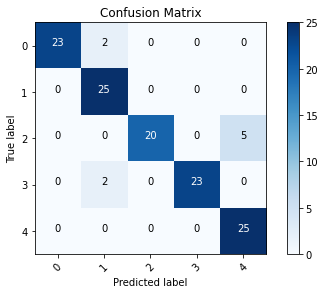

In [60]:
cm_plot_labels = ['0','1','2','3','4']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')